### Megaline Subscriber Analysis

The following project will analyize subsciber behavior to help in determining what type of model has better accuracy finding the more popular plan, Ultra or Smart.

We have access to behavior data about subscribers who have already switched to the new plans. For this classification task, we need to develop a model that will pick the right plan. Since we’ve already performed the data preprocessing step, we can move straight to creating the model.

In this project, the threshold for accuracy is 0.75 and will be checked by using the test dataset.

### Project Steps to take:
- Open and look through the data file. Path to the file:datasets/users_behavior.csv Download dataset
- Split the source data into a training set, a validation set, and a test set.
- Investigate the quality of different models by changing hyperparameters. Briefly describe the findings of the study.
- Check the quality of the model using the test set.
- Additional task: sanity check the model. This data is more complex than what you’re used to working with, so it's not an easy task. We'll take a closer look at it later.

### Data description
Every observation in the dataset contains monthly behavior information about one user. The information given is as follows:
- сalls — number of calls,
- minutes — total call duration in minutes,
- messages — number of text messages,
- mb_used — Internet traffic used in MB,
- is_ultra — plan for the current month (Ultra - 1, Smart - 0).

## Preparing the Data
- Download the data
- Inspect and clean the data
- Explore the data
- Mold the data to Tidy data <i>(Tidy data is data that is easy to manipulate, model and visualize)</i>

#### Import Libraries

In [1]:
import pandas as pd                              #dataframe library
import numpy as np                               #numpy provides n-dim object support
import matplotlib.pyplot as plt                  #plotting library
import seaborn as sns                            #plotting library

In [2]:
#Sklearn Libraries
from sklearn.tree import DecisionTreeClassifier      #decision tree classifications
from sklearn import set_config
from sklearn.metrics import accuracy_score           #used in determining accuracy
from sklearn.model_selection import train_test_split #splitting dataframes
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Load and Review Data

In [3]:
#Since we are working with csv files, using the sep function to handle the data in the spreadsheets
try:
    behavior = pd.read_csv('users_behavior.csv',sep=',')
    
except:
    behavior = pd.read_csv('/datasets/users_behavior.csv', sep=',')

In [4]:
behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
behavior.shape

(3214, 5)

The original dataset consists of 3214 rows with 5 columns

#### Check for null values

In [6]:
behavior.isnull().values.any() # The use of 'any' will return a 'True' if any nulls are found.

False

In [7]:
behavior.info() #overview of data types we are working with and basic information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [8]:
#check for NAs
behavior.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

No 'NA' values have been found in the dataset.

<b>Insight:</b> We need to make sure our data does not contain missing values as most machine algorithims cannot work with missing data. (NA/NaN) 

In [9]:
#check for duplicates
duplicate = behavior[behavior.duplicated()]
duplicate

,calls,minutes,messages,mb_used,is_ultra


No missing values or duplicates

### Check Smart/Ultra ratio

In [10]:
is_smart= len(behavior.loc[behavior['is_ultra'] == 0])
is_ultra= len(behavior.loc[behavior['is_ultra'] == 1])

print("Number of Smart plans: {0} ({1:2.2f}%)".format(is_smart, (is_smart/(is_smart+is_ultra))*100))
print("Number of Ultra plans: {0} ({1:2.2f}%)".format(is_ultra, (is_ultra/(is_smart+is_ultra))*100))

Number of Smart plans: 2229 (69.35%)
Number of Ultra plans: 985 (30.65%)


<b>Insight:</b> Smart Plans comprise almost 70% of the user base while the Ultra plan makes up the remaining 30% of users.  With Smart plans having such a strong hold on user base, so far the Smart plans is the most popular. 

### Brief EDA

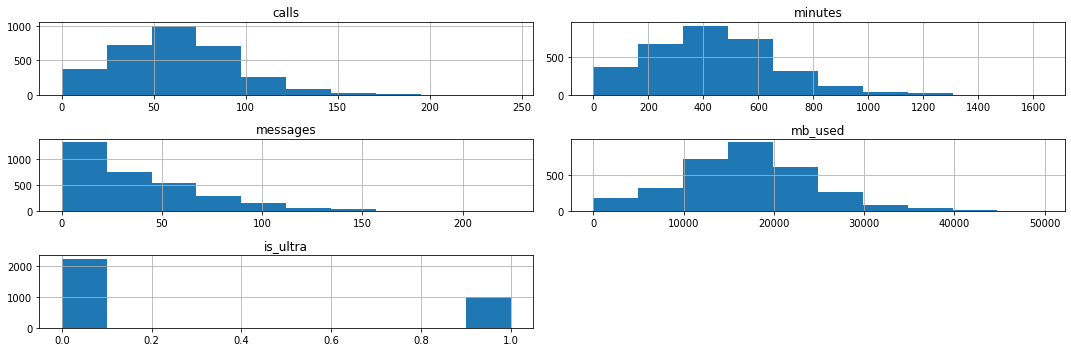

In [11]:
behavior.hist(linewidth=1.5, figsize=(15,5));
plt.tight_layout()
plt.show()

<b>Insights:</b> The above histogram plots give a graphical representation of the data. We can see how many calls users typically make, how many minutes they use on their plan, number of messages sent, data used and which plan has the most users.  The calls, minutes and mb_used plots are pretty much identical due to their properties. Higher calls = higher minutes = more data (mb) used.
<p>
The 'features' of the dataset seem fairly balanced, no glaring anomalies are shown. We can already see what the most used plan is from the 'is_ultra' histogram. Now to determine which model would give us the greatest accuracy to prove what we are seeing. 

## Solution Creation

Using the Machine Learning Workflow to process and transfrom user behavior data to create prediction models. These models will analyze users behavior and from the model with the highest possible accuracy; we can use that to determine the best mobile plan.

## 2. Split the source data into a training set, a validation set, and a test set.

Using more functions from the sklearn library, the original dataset will be split into a Training, Validation and Test sets. The Training set will consist of 60% of the dataset with the Test and Validation taking 20% each.  

In [12]:
from sklearn.model_selection import train_test_split 

In [13]:
#20% of dataset used as TESTING SET and rest as training. TEST set used as final test.
behavior_train_full, behavior_test = train_test_split(behavior, test_size = 0.2, random_state=12345) 

#splitting training dataset to get validation set. Use .25 as 20/80 is .25.  after the test set we have 80% left
behavior_train, behavior_valid = train_test_split(behavior_train_full, test_size = 0.25, random_state=12345)
#using behavior_train_full as that is our original df for splitting. 
#it's what we got our testing set from so use to get validation set


In [14]:
# lets see the set sizes

print(behavior_train.shape)
print(behavior_valid.shape)
print(behavior_test.shape)

(1928, 5)
(643, 5)
(643, 5)


The Validation and Test sets are the same (20% each) and the Training set at the desired 60% (3x the validation and test sets)

### Features and Target

Now to take only the columns relevant to our analysis and create separate dataframes.  We will take the 'features' and separate them from our 'target', which are the phone plans.  For this, training and validation sets will be used. 

In [15]:
#Features - this will separate the dataframe to show only the features
features_train= behavior_train.drop(['is_ultra'], axis=1) #this drops the 'is_ultra' column as that is our target
target_train = behavior_train['is_ultra']
features_valid = behavior_valid.drop(['is_ultra'], axis=1)
target_valid = behavior_valid['is_ultra']

In [16]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)


In [17]:
#Features df and overview
features_train.head()

,calls,minutes,messages,mb_used
2656,30.0,185.07,34.0,17166.53
823,42.0,290.69,77.0,21507.03
2566,41.0,289.83,15.0,22151.73
1451,45.0,333.49,50.0,17275.47
2953,43.0,300.39,69.0,17277.83


In [18]:
#Target df and overview
target_train.head()

2656    0
823     0
2566    0
1451    0
2953    0
Name: is_ultra, dtype: int64

Luckily our target variables are already numeric values so nothing needs to be encoded (changed)!

## 3. Investigate the quality of different models by changing hyperparameters. Briefly describe the findings of the study.

In this section we are going to figure out the best hyperparameters for each of the 3 learning algorithms:

- Decision Tree
- Random Forest
- Logistic Regression

### Decision Tree

In [19]:

for depth in range(1, 10):
    # create a model with the given depth
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)#classifier as using category of 0 or 1 to phone plan
    model.fit(features_train, target_train) # train the model
    predictions_valid = model.predict(features_valid) #find the predictions using validation set. get the model's predictions
    dt_acc = round(accuracy_score(target_valid, predictions_valid)*100,2)
    
    print('max_depth =', depth, ': ', end='')
    print(dt_acc) # calculate the accuracy and format the result
    

max_depth = 1 : 73.87
max_depth = 2 : 75.74
max_depth = 3 : 76.52
max_depth = 4 : 76.36
max_depth = 5 : 75.89
max_depth = 6 : 75.74
max_depth = 7 : 77.45
max_depth = 8 : 76.67
max_depth = 9 : 76.21


<b>Insight:</b> From the above descision tree loop, depth 7 gave the best accuracy of 77.45% using the validation set. This means for all of the values we attempted to predict, 77.45% of them were correct.
<p>
A deeper tree may mean higher performance for the training data, but it can lead to overfitting so tree depth is kept at 10.  We can see after depth 7 that the percentage is starting to decline.

### Random Forest Classifier

Decision trees are prone to overfitting. However, you can remove this problem by using a random forest; the automated handling of creating more decision trees. 

In [20]:
best_score = 0
best_est = 0
model_forest = None

for est in range(1, 10): #using same range as decision tree
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
    model.fit(features_train, target_train)
    rfc_score = round(model.score(features_valid, target_valid)*100,2)# round()*100,2 will format the running decimal to a percent
    
    if rfc_score > best_score:
        best_score = rfc_score
        best_est = est
        model_forest = model

print(f"Best accuracy: {best_score} obtained using {best_est} trees with\
 max_depth {depth}.")


Best accuracy: 79.63 obtained using 3 trees with max_depth 9.


The Random Forest model provides the best level of accuracy so far at 79.63%; better than any of the descision tree levels.  It's also better than our threshold which is 75%

### Logistic Regression

Logistic regression aims to solve classification problems. It does this by predicting categorical outcomes

In [21]:
# initialize logistic regression constructor with parameters random_state=54321 and solver='liblinear'
model =  LogisticRegression(random_state=12345, solver='liblinear') 
model.fit(features_train, target_train)
score_train = round(model.score(features_train, target_train)*100,2)
score_valid = round(model.score(features_valid, target_valid)*100,2)

print(
    "Accuracy of the logistic regression model on the training set:",
    score_train,"%"
)
print(
    "Accuracy of the logistic regression model on the validation set:",
    score_valid,"%"
)

Accuracy of the logistic regression model on the training set: 74.22 %
Accuracy of the logistic regression model on the validation set: 72.94 %


The Logistic Regression model performed below both of the other models we tested. The threshold for accuracy was 75% and both the training and validation sets are below that threshold. The lower validation accuracy may indicate some overfitting.

## 4. Check the quality of the model using the test set.


In [22]:
# Test Set
features_test = behavior_test.drop(['is_ultra'], axis=1)
target_test = behavior_test['is_ultra']


In [23]:
from sklearn.metrics import accuracy_score

In [24]:
y_pred = model_forest.predict(features_test)

accuracy = round(accuracy_score(target_test, y_pred)*100,2)

# Create a pandas DataFrame to store the evaluation results
evaluation_results = pd.DataFrame({
    "Metric": ["Accuracy"],
    "Score": [accuracy]
})

print("Evaluation Results for the Best Model:")
print(evaluation_results)

Evaluation Results for the Best Model:
     Metric  Score
0  Accuracy  79.32


Checking the quality of our Random Forest model against the test set, our accuracy is still high with 79.32% 

## 5. Sanity check the model

DummyClassifier makes predictions that ignore the input features. This classifier serves as a simple baseline to compare against other more complex classifiers. If we don’t know how our model is performing against a baseline, how can we improve it?
<p>
    
Below are the links that aided in the sanity check:    

__[Simple Sanity Check](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)__

__[DummyClassifier Tutorial](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)__

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
# Dummy Model

# random_state controls the randomness to generate the prediction
#“most_frequent”: the predict method always returns the most frequent class label in the observed y argument passed to fit
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(features_train, target_train) #'target_train' is the y argument

DummyClassifier(random_state=0, strategy='most_frequent')
dum_acc = round(clf.score(features_test, target_test)*100,2)
print("Accuracy of Dummy Model:", dum_acc,"%")

Accuracy of Dummy Model: 69.52 %


Using the sckit learn website, a simply way to check the Sanity of our models was found.  There is now a baseline accuracy percentage that the other models can be compared to. This will be done below. 

In [27]:
#creating a small df to hold the modeling results
model_results = pd.DataFrame({'Decision Tree' : [77.45], #values are manually entered
                        'Random Forest': [79.63],
                        'Logistic Regression': [72.49],
                        'Dummy Model'  : [69.52]
                        })
model_results.T.sort_values(by=0, ascending=False) #The T attribute after the DataFrame is used to transpose the DataFrame. 

,0
Random Forest,79.63
Decision Tree,77.45
Logistic Regression,72.49
Dummy Model,69.52


<i><b>Coding Note:</b> Since the small 'model_results' dataFrame has rows that contain data for different variables and columns that contain data for different observations, applying ".T" will flip it, making the rows represent observations and columns represent variables. Calling the '.sort_values()' method on the transposed DataFrame to sort it by the values in the column labeled 0 in descending order (as indicated by ascending=False)</i>

<b>Insight:</b> Now that there is a baseline accuracy reference, we can compare how our models did. Our Random Forest model performed better than expected at 79.63%.  Even though the Decision Tree returned multiple values from the max_depth loops, it still underperfromed to the Random Forest but the difference is less than a percent. 

***

## Conclusion:

This project used various modeling algorithums based on binary classification to analyze customer behavior and recommends one of Megaline mobile plans: Smart or Ultra plans.

#### Prep and EDA
The analysis was started by preparing and inspecting the data. There were no missing or duplicated values. Next some brief exploratory data analysis was conducted to take a further look into the data we were working with. Our 'features' showed no significant anomalies and were fairly balanced from the plot overviews. The calls, minutes and mb used are related so the histograms appear to be replicated but there were slight differences. 

Our 'taget' variable on the other hand showed a significant differnce and it's clear to see which of Megaline's plans it's customers perfer. Megaline's "Smart" plan is already 70% of it's customer's base. This imbalance may skew our modeling results. Luckily the target data type was already set in a 1's and 0's format for analysis and no encoding was needed. 

#### Modeling Algorithms
After preparing and exploring the data, our next approach is modeling machine learning algorithms to the highest level of accuracy. This is done by first splitting our dataset into Training, Validation and Testing sets. 

The Random Forest model showed the highest accuracy at 79.63% on our validation set. Decision Tree and Logistic Regression were also used in the modeling process with Logistic Regression having the lowest accuracy percentage out of the 3 models. 


#### Quality and Sanity Checks
To end out the analysis, we compared the quality of the models against the test set.  We used both the training and validation sets. The test set accuracy was right at our threshold of 75% followed by the training set at 74.2% and the validation set at almost 73%. 

Final step was to sanity check our model. To begin a baseline accuracy was found and the other learning models were compared to that. Against the baseline, our best learning model the Random Forest, was 10.11 percentage points more. 